In [2]:
import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as py
import torchvision.models as models

In [3]:
def data_pipe(batch_size,data_dir='data'):
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    train_data = datasets.FashionMNIST(data_dir,download=True,train=True,transform=transform)
    test_data = datasets.FashionMNIST(data_dir,download=True,train=False,transform=transform)
    train = DataLoader(train_data,shuffle=True,batch_size=batch_size)
    test = DataLoader(test_data,shuffle=True,batch_size=batch_size)
    return train,test

In [4]:
def get_class_names():
    return [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]

def get_class_index(name):
    return get_class_names().index(name)

def get_class_name(index):
    return get_class_names()[index]

In [5]:
train,test = data_pipe(64)

In [6]:
first = next(iter(train))


In [7]:
im, label = first

In [8]:
label

tensor([7, 3, 5, 4, 9, 5, 9, 2, 4, 5, 7, 3, 1, 0, 3, 5, 3, 3, 7, 8, 8, 0, 1, 1,
        9, 5, 2, 4, 5, 4, 1, 8, 6, 9, 7, 9, 4, 9, 6, 7, 3, 8, 4, 7, 4, 8, 4, 0,
        1, 1, 3, 7, 3, 0, 4, 9, 4, 3, 9, 4, 8, 4, 1, 9])

In [9]:
first_test = next(iter(test))

In [10]:
first_test[0][0].size()

torch.Size([1, 28, 28])

In [11]:
check = np.array(first[0][0])

In [12]:
check = check*0.5 + 0.5

In [13]:
check = check[0]

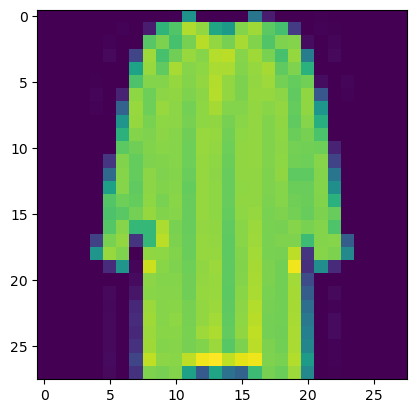

In [14]:
py.imshow(first[0][1].squeeze())

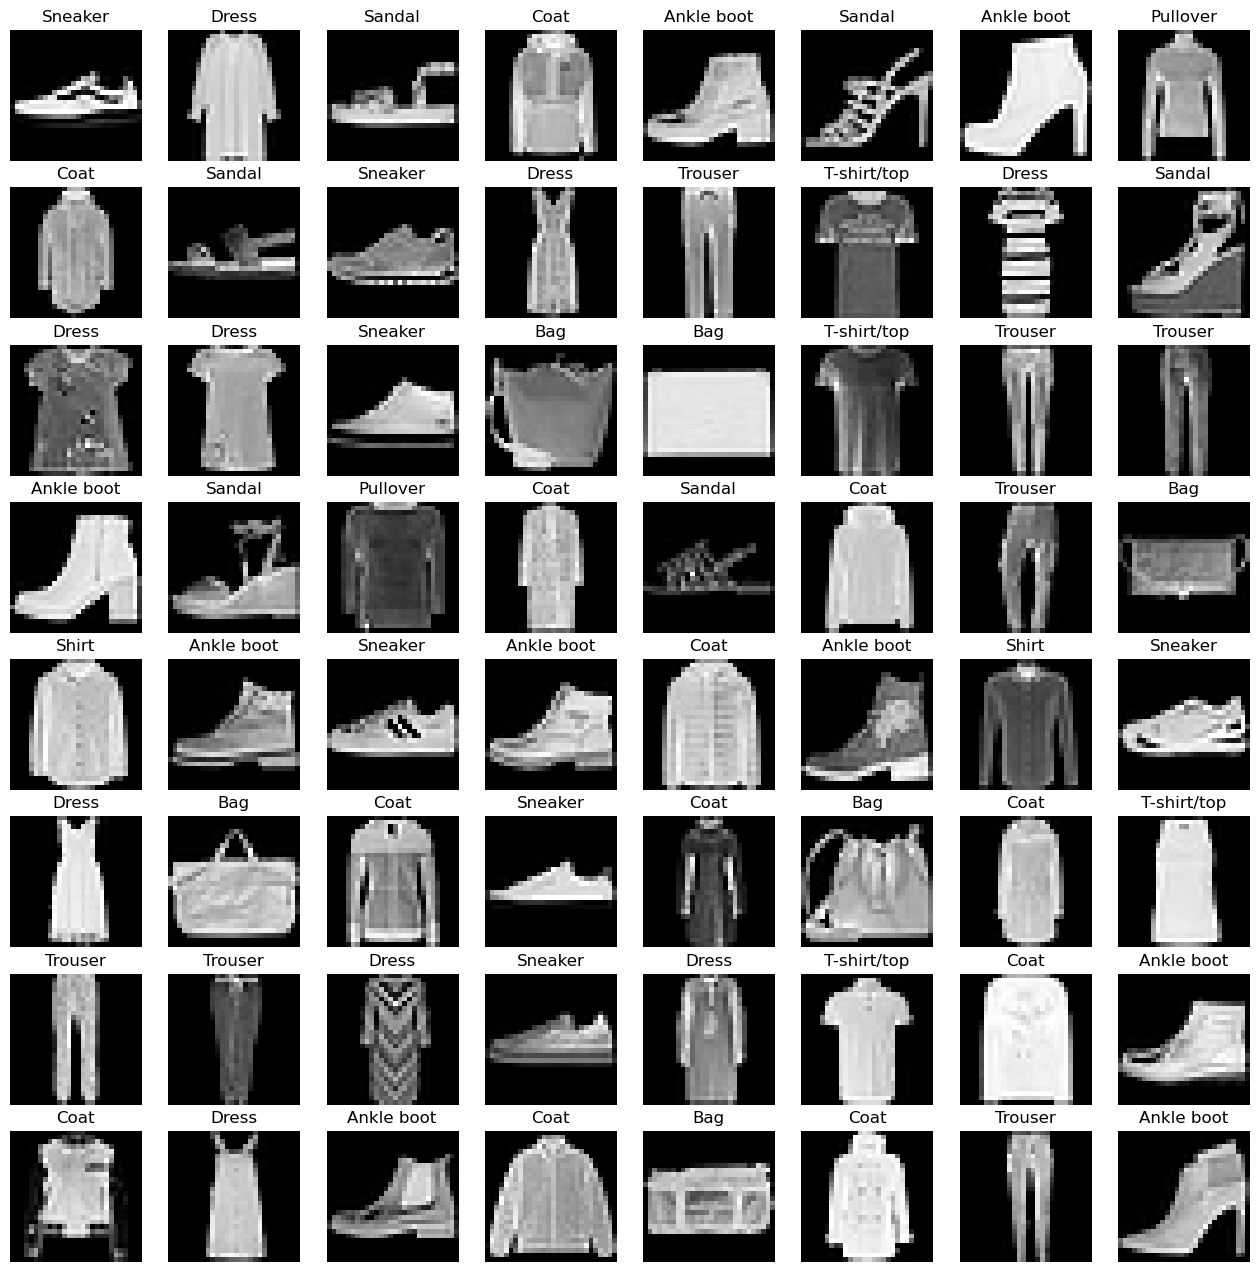

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(8,8, figsize=(16, 16))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(((np.array(im[i]) * 0.5 + 0.5).squeeze()), cmap='gray')  # Assuming grayscale image
    ax.axis('off')  # Turn off axis
    ax.set_title(get_class_name(label[i]))

plt.show()


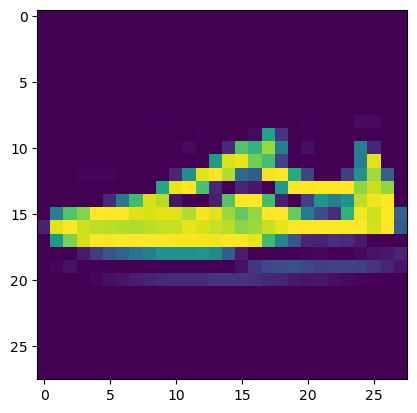

In [16]:
plt.imshow((np.array(im[0])*0.5 + 0.5).squeeze())

In [17]:
im.size()

torch.Size([64, 1, 28, 28])

In [18]:
m_net = models.mobilenet_v3_small(pretrained=True)

/home/gagandeep/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gagandeep/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
class m_net_out(nn.Module):
    def __init__(self):
        super(m_net_out,self).__init__()
        self.model = models.mobilenet_v3_small(pretrained=True)
        self.model.classifier[3]= nn.Linear(1024,10)
        self.freeze()
    def forward(self,x):
        x = x.repeat(1,3,1,1)
        if x.shape[2:] != (224,224):
            x = nn.functional.interpolate(x,size=(224,224),mode='bilinear',align_corners=False)
        return self.model(x)
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad=False
        for param in self.model.classifier[3].parameters():
            param.requires_grad=True
    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad=True

        

In [20]:
model = m_net_out()

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [22]:
import torch.nn.functional as F

epochs = 1
for epoch in range(epochs):
    total = 0
    for index, (img, labels) in enumerate(train):
        optimizer.zero_grad()  # Zero the gradients
        preds = model(img)  # Forward pass
        preds_softmax = F.softmax(preds, dim=1)  # Apply softmax to convert logits to probabilities
        
        # Compute the loss
        loss = loss_fn(preds_softmax, labels)  
        
        # Backpropagation
        loss.backward()  
        
        # Update the parameters
        optimizer.step()  
        
        # Accumulate the total loss for the epoch

In [23]:
i,l = next(iter(train))

In [24]:
p = model(i)

In [25]:
c = nn.functional.softmax(p, dim=1)

In [26]:
loss_fn(c,l)

tensor(1.5948, grad_fn=<NllLossBackward0>)

In [27]:
l.shape[0]

64

In [31]:
total_correct = 0
total_loss = 0
total = 0
for images,labels in test:
    
    out = model(images)
    loss += loss_fn(out,labels)
    out = torch.max(out,1)[1]
    total_correct += (labels == out).sum().item()
    total += labels.size(0)

print(total_correct/total)
print(total)
    

0.8422
10000


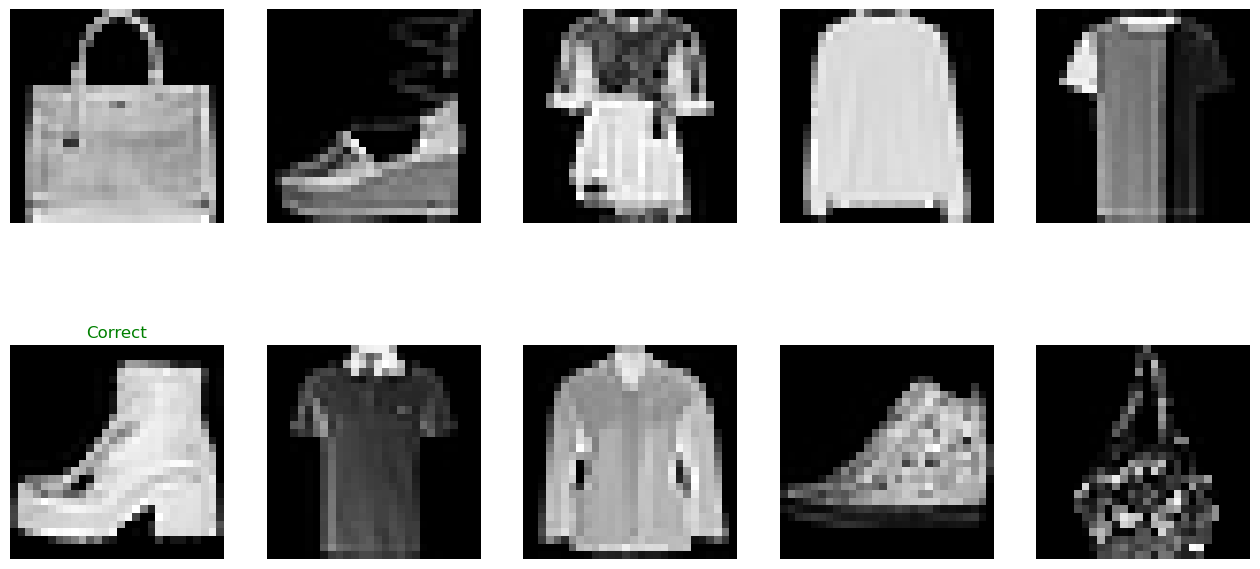

In [68]:
test_im, test_labels = next(iter(test))
fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i in range(10):
    row = i // 5
    col = i % 5
    ax[row, col].imshow(((((np.array(test_im[i]) * 0.5 + 0.5)).squeeze())), cmap='gray')  # Assuming grayscale image
    pred = torch.max(model(im[i]),1)[1]
    if pred == test_labels[i]:
        ax[row, col].set_title('Correct', color='green')  # Set title to 'Correct' and color it green if prediction is correct
    ax[row, col].axis('off')

plt.show()


In [64]:
torch.max(model(test_im[1]),1)[1]

tensor([2])

In [65]:
test_labels[1]

tensor(5)